In [22]:
import time
import pandas as pd
import numpy as np
import datetime
import os
import gc
from functools import partial
import matplotlib.pyplot as plt
from utils import load_data, get_logger, get_data_path
from clean_session import preprocess_sessions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
train_input = pd.read_parquet('./cache/train_inputs_no_imp.snappy')

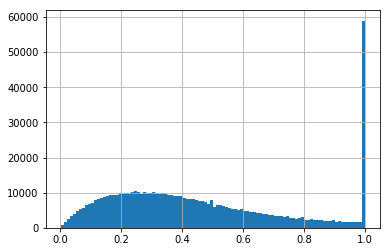

In [85]:
train_input.price_24.hist(bins=100)

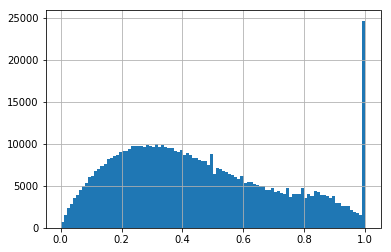

In [87]:
train_input.price_10.hist(bins=100)

In [83]:
train_input.groupby('target')['price_24'].value_counts().groupby(level=0).head()

target  price_24
0       1.000000    16204
        0.500000      991
        0.333333      779
        0.250000      561
        0.400000      488
1       1.000000     6294
        0.500000      240
        0.333333      141
        0.400000      127
        0.666667      118
2       1.000000     4490
        0.500000      143
        0.333333      110
        0.400000       86
        0.250000       74
3       1.000000     3639
        0.500000      144
        0.333333       97
        0.250000       63
        0.400000       62
4       1.000000     3034
        0.500000      132
        0.333333       90
        0.250000       70
        0.666667       63
5       1.000000     2578
        0.500000       85
        0.333333       69
        0.250000       51
        0.666667       46
                    ...  
19      1.000000      810
        0.500000       32
        0.333333       20
        0.400000       20
        0.750000       20
20      1.000000      834
        0.500000     

In [77]:
train_input[[f'price_{i}' for i in range(25)]].describe()

,price_0,price_1,price_2,price_3,price_4,price_5,price_6,price_7,price_8,price_9,...,price_15,price_16,price_17,price_18,price_19,price_20,price_21,price_22,price_23,price_24
count,628594.000000,628594.000000,628594.000000,628594.000000,628594.000000,628594.000000,628594.000000,628594.000000,628594.000000,628594.000000,...,628594.000000,628594.000000,628594.000000,628594.000000,628594.000000,628594.000000,628594.000000,628594.000000,628594.000000,628594.000000
mean,0.467569,0.464769,0.464206,0.462470,0.461797,0.460571,0.459794,0.459060,0.458492,0.457109,...,0.449848,0.448906,0.448797,0.449403,0.448228,0.448487,0.449358,0.449195,0.449493,0.450674
std,0.268367,0.257093,0.256529,0.256316,0.255955,0.256320,0.257859,0.258028,0.258907,0.260516,...,0.265674,0.265922,0.267327,0.269817,0.269704,0.271420,0.274295,0.274794,0.276542,0.279627
min,0.001002,0.001062,0.001064,0.001112,0.000778,0.000801,0.000650,0.000600,0.000778,0.000503,...,0.001000,0.001200,0.000900,0.000758,0.001164,0.001224,0.001200,0.001000,0.001000,0.001217
25%,0.253435,0.261111,0.260754,0.258537,0.258427,0.256100,0.253731,0.252396,0.251462,0.248590,...,0.237875,0.236968,0.235899,0.234323,0.233674,0.232966,0.231183,0.231343,0.230769,0.229630
50%,0.428571,0.431219,0.430380,0.427522,0.426557,0.423621,0.421348,0.420000,0.418605,0.415505,...,0.400000,0.398693,0.397590,0.396396,0.395349,0.393617,0.392405,0.391960,0.391304,0.390288
75%,0.647826,0.638252,0.640000,0.640000,0.640954,0.641176,0.641975,0.641892,0.642202,0.641221,...,0.629213,0.626866,0.626087,0.627156,0.623711,0.623762,0.625899,0.623656,0.622951,0.625000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
from create_model_inputs import compute_session_fts, prepare_data, flogger

In [14]:
logger = get_logger('create_model_inputs')
Filepath = get_data_path()


In [41]:
mode='train'
nrows=1000000
logger.info(f'Prepare {mode} data')
t_init = time.time()
df = prepare_data(mode, convert_action_type=True, nrows=nrows, recompute=False)
logger.info('Compute session features')

[05-17 21:29:26 - create_model_inputs-3 - <module> - INFO] Prepare train data
[05-17 21:29:27 - utils-106 - load_data - INFO] Loading train using 1,000,000 rows (999,995 trimmed) which is 6.28% out of total train data
[05-17 21:29:27 - create_model_inputs-17 - flogger - INFO] raw train shape: (999,995, 12)
[05-17 21:29:27 - clean_session-56 - preprocess_sessions - INFO] Load from existing file: ./cache/preprocessed_train.snappy
[05-17 21:29:28 - create_model_inputs-74 - prepare_data - INFO] Converting action_types to int (natural number)
[05-17 21:29:28 - create_model_inputs-25 - create_action_type_mapping - INFO] Load action_types mapping from existing: ./cache/action_types_mapping.npy
[05-17 21:29:28 - create_model_inputs-77 - prepare_data - INFO] Sort df by user_id, session_id, timestamp, step
[05-17 21:29:28 - create_model_inputs-17 - flogger - INFO] Prepared train data shape: (326,695, 9)
[05-17 21:29:28 - create_model_inputs-6 - <module> - INFO] Compute session features


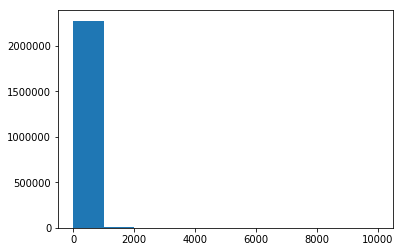

In [42]:
str_prices = np.concatenate(df.prices.dropna().str.split('|').values)
str_prices = [int(sp) for sp in str_prices]
# pd.value_counts(str_prices)
_ = plt.hist(str_prices)

In [25]:
%%time
df = compute_session_fts(df, mode)

[05-17 21:24:03 - create_model_inputs-125 - compute_session_fts - INFO] Session features generated: ['timestamp_session_duration', 'timestamp_dwell_time_prior_clickout', 'session_id_size']


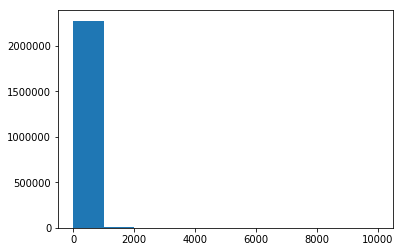

In [43]:
str_prices = np.concatenate(df.prices.dropna().str.split('|').values)
str_prices = [int(sp) for sp in str_prices]
# pd.value_counts(str_prices)
_ = plt.hist(str_prices)

In [44]:
logger.info('Only select last click-out from each session')
df = df.groupby('session_id').last().reset_index()
flogger(df, 'df shape after only selecting last click-out row each session')

# # log-transform on session_size feature
# logger.info('Log-transform on session_size feature')
# df['session_id_size'] = np.log(df['session_id_size'])

# # log1p-transform on timestamp_dwell_time_prior_clickout but will cliping upper to 1hr
# logger.info('Also log-transform on timestamp_dwell_time_prior_clickout but will cliping upper to 1hr')
# df['timestamp_dwell_time_prior_clickout'] = np.log1p(df['timestamp_dwell_time_prior_clickout'].clip(upper=60 ** 2))

[05-17 21:29:47 - create_model_inputs-1 - <module> - INFO] Only select last click-out from each session
[05-17 21:29:47 - create_model_inputs-17 - flogger - INFO] df shape after only selecting last click-out row each session shape: (51,962, 9)


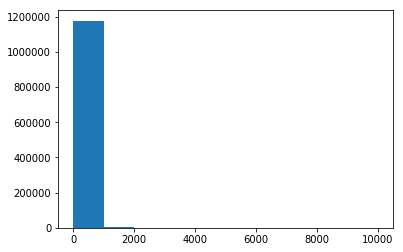

In [45]:
str_prices = np.concatenate(df.prices.dropna().str.split('|').values)
str_prices = [int(sp) for sp in str_prices]
# pd.value_counts(str_prices)
_ = plt.hist(str_prices)

In [46]:
df['prices'] = df['prices'].str.split('|')
df['prices_int'] = df['prices'].apply(lambda x: [int(p) for p in x])

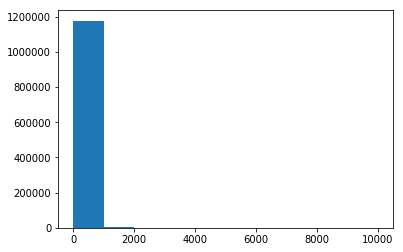

In [47]:
str_prices = np.concatenate(df.prices_int.dropna().values)
# pd.value_counts(str_prices)
_ = plt.hist(str_prices)

In [48]:
df['time_steps'] = df['prices_int'].str.len()
padding_mask = df['time_steps'] < 25
df.drop('time_steps', axis=1, inplace=True)

In [51]:
df.prices.head()

0    [74, 88, 87, 72, 56, 87, 244, 168, 123, 50, 12...
1    [79, 241, 96, 51, 68, 99, 86, 69, 71, 79, 91, ...
2    [466, 193, 295, 331, 171, 347, 383, 557, 106, ...
3    [144, 372, 139, 141, 109, 84, 74, 168, 78, 89,...
4    [97, 101, 78, 75, 99, 60, 120, 78, 188, 136, 9...
Name: prices, dtype: object

In [52]:
df.prices.iloc[0]

['74',
 '88',
 '87',
 '72',
 '56',
 '87',
 '244',
 '168',
 '123',
 '50',
 '129',
 '72',
 '151',
 '83',
 '230',
 '88',
 '59',
 '450',
 '138',
 '88',
 '100',
 '111',
 '185',
 '72',
 '37']

In [58]:
df[df.prices.str.len()<25].prices.iloc[0]

['144',
 '372',
 '139',
 '141',
 '109',
 '84',
 '74',
 '168',
 '78',
 '89',
 '100',
 '68',
 '139',
 '189']

In [73]:
x = [int(i) for i in df[df.prices.str.len()<25].prices.iloc[0]]
x

[144, 372, 139, 141, 109, 84, 74, 168, 78, 89, 100, 68, 139, 189]

In [74]:
np.pad(x, (0, 25-len(x)), mode='constant', constant_values=0)

array([144, 372, 139, 141, 109,  84,  74, 168,  78,  89, 100,  68, 139,
       189,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [70]:
type(np.nan)

float

In [49]:
df.loc[padding_mask, 'prices_int'] = df.loc[padding_mask, 'prices_int'].apply(lambda x: np.pad(x, (0, 25-len(x)),
                                                                                       mode='constant',
                                                                                       constant_values=np.nan))

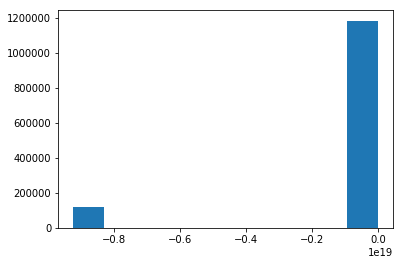

In [50]:
str_prices = np.concatenate(df.prices_int.dropna().values)
# pd.value_counts(str_prices)
_ = plt.hist(str_prices)

In [ ]:
def normalize(ps):
    p_arr = np.array(ps)
    return p_arr / (p_arr.max())
df['prices_percentage_int'] = df['prices'].apply(normalize)